In [23]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.)

20.0

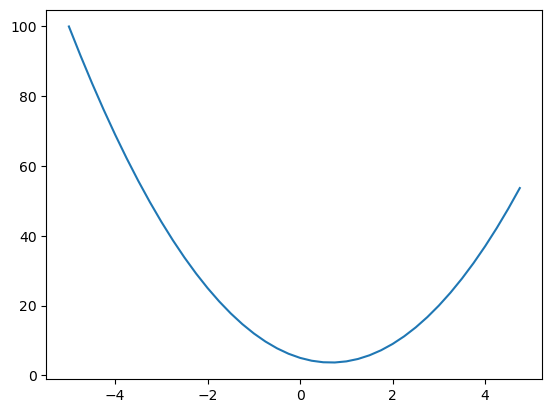

In [6]:
xs = np.arange(-5.0, 5.0, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.001
x = -3.0
print(f(x))
print(f(x+h))

44.0
43.978003


In [8]:
((f(x+h)-f(x)))/h

-21.996999999998934

In [9]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [34]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * self.data**(other-1)
        out._backward = _backward
            
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        n = self.data
        t =  (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [12]:
a = Value(2.)
b = Value(4.)
a / b

Value(data=0.5)

In [13]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        

In [14]:
draw_dot(L)

NameError: name 'L' is not defined

In [ ]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0
c.grad = -2.0
e.grad = -2.0

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

In [ ]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = f*d; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    a.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = f*d; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)

lol()

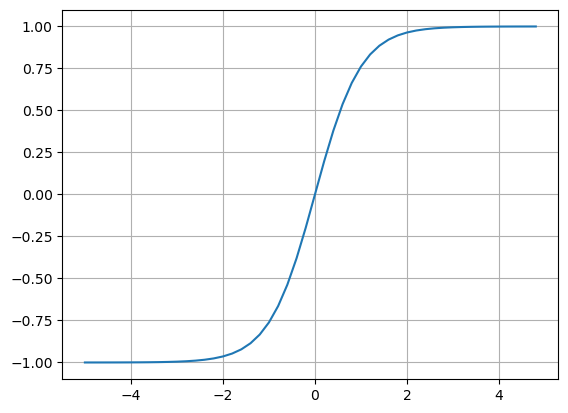

In [15]:
x = np.arange(-5,5,0.2)
y = np.tanh(x)
plt.plot(x, y)
plt.grid()

In [16]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

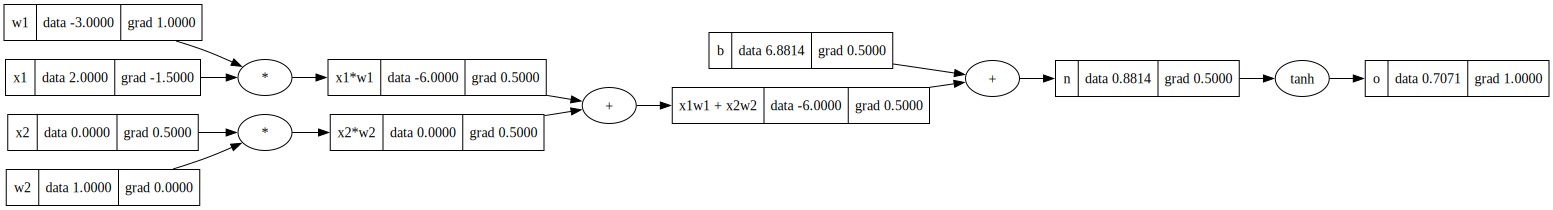

In [17]:
draw_dot(o)

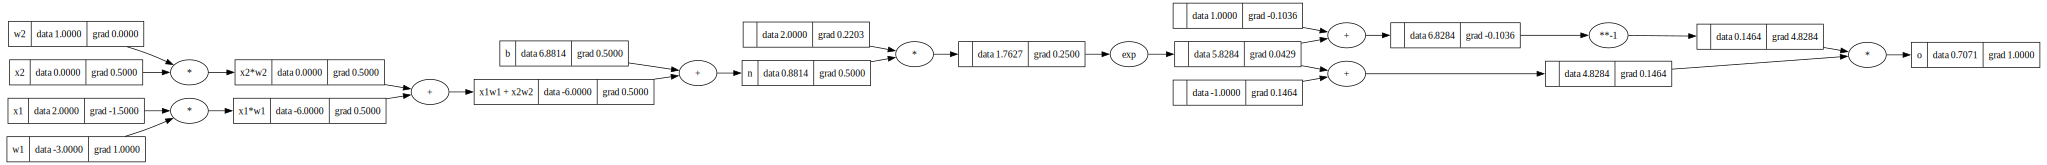

In [18]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# --- 
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

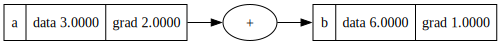

In [19]:
# overwriting, using same variable more than once
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

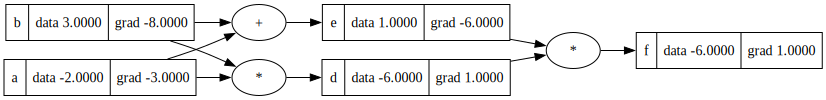

In [20]:
# more complicated example
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

# Making the Neurons

In [62]:
class Neuron:
    # number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [weight for neuron in self.neurons for weight in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [106]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.49668084042337085)

In [107]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [118]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update 
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.010959682259508741
1 0.010860898426754405
2 0.010763849169679013
3 0.010668489520928321
4 0.010574776047577126
5 0.0104826667864243
6 0.010392121182527374
7 0.010303100030789873
8 0.010215565420425461
9 0.010129480682136285
10 0.010044810337850861
11 0.009961520052879766
12 0.0098795765903537
13 0.009798947767818075
14 0.009719602415867125
15 0.009641510338705679
16 0.009564642276535456
17 0.009488969869668084
18 0.009414465624273156
19 0.009341102879675598


In [119]:
ypred

[Value(data=0.9593960624138119),
 Value(data=-0.9609504399105551),
 Value(data=-0.9399941073676754),
 Value(data=0.9493359314859998)]

In [110]:
loss

Value(data=0.09967874395044293)

In [98]:
nloss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
nloss

[Value(data=5.4807849871209696e-18),
 Value(data=3.999992955764876),
 Value(data=1.0191155333333996e-09),
 Value(data=5.5690213647451814e-18)]

In [99]:
ys

[1.0, -1.0, -1.0, 1.0]

In [100]:
ypred

[Value(data=0.9999999976588924),
 Value(data=0.9999982389404435),
 Value(data=-0.9999680764110205),
 Value(data=0.9999999976401226)]